In [14]:
import numpy as np 
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
# 1/ Training data :

column_names = ['Model_name', 'input_shape', 'ACET', 'input_width', 'input_size', 'model_size', 'nb_params_no_fc', 
                'nb_params_fc', 'flops', 'nb_layers', 'nb_conv_layers', 'nb_fc_layers', 
                'sum_activations', 'weighted_sum_neurones']
raw_dataset = pd.read_csv('./training_dataset.csv', names=column_names,
                      na_values = "?", comment='\t', sep=",", skipinitialspace=True)
train_dataset = raw_dataset.copy()
train_dataset.isna().sum()
train_dataset = train_dataset.dropna()
train_dataset.tail()

,Model_name,input_shape,ACET,input_width,input_size,model_size,nb_params_no_fc,nb_params_fc,flops,nb_layers,nb_conv_layers,nb_fc_layers,sum_activations,weighted_sum_neurones
1521,DPN-137,"(1, 480, 480, 3)",236.347517,480,691200,319.7,76725504,2688000,147429883398,4072,1811,1,761714152,74962944000
1522,DPN-137,"(1, 568, 568, 3)",306.702618,568,967872,319.7,76725504,2688000,210363824006,4072,1811,1,1079996072,107007131648
1523,DPN-137,"(1, 600, 600, 3)",331.850612,600,1080000,319.7,76725504,2688000,234455319558,4072,1811,1,1204310184,119281811456
1524,DPN-137,"(1, 800, 800, 3)",520.859203,800,1920000,319.7,76725504,2688000,408964654598,4072,1811,1,2115851752,208230400000
1525,DPN-137,"(1, 896, 896, 3)",650.251626,896,2408448,319.7,76725504,2688000,512924726150,4072,1811,1,2654121448,261204213760


In [91]:
# 1/ Test data :

column_names = ['Model_name', 'input_shape', 'ACET', 'input_width', 'input_size', 'model_size', 'nb_params_no_fc', 
                'nb_params_fc', 'flops', 'nb_layers', 'nb_conv_layers', 'nb_fc_layers', 
                'sum_activations', 'weighted_sum_neurones']
raw_dataset = pd.read_csv('./test_dim3.csv', names=column_names,
                      na_values = "?", comment='\t', sep=",", skipinitialspace=True)
test_dataset = raw_dataset.copy()
test_dataset.isna().sum()
test_dataset = test_dataset.dropna()
test_dataset.tail()

,Model_name,input_shape,ACET,input_width,input_size,model_size,nb_params_no_fc,nb_params_fc,flops,nb_layers,nb_conv_layers,nb_fc_layers,sum_activations,weighted_sum_neurones
19,NASNet-Mobile,"(1, 331, 331, 3)",16.397280,331,328683,22.2,4269716,1057000,2629916665,771,196,1,62189815,9731133896
20,NASNet-Large,"(1, 64, 64, 3)",49.317171,64,12288,357.0,84916818,4033000,1868148675,1041,268,1,10813366,6709743072
21,NASNet-Large,"(1, 128, 128, 3)",53.963382,128,49152,357.0,84916818,4033000,6917229891,1041,268,1,42382774,26839800288
22,NASNet-Large,"(1, 256, 256, 3)",80.010125,256,196608,357.0,84916818,4033000,27115250499,1041,268,1,168061366,107360877024
23,NASNet-Large,"(1, 331, 331, 3)",110.658881,331,328683,357.0,84916818,4033000,47876527473,1041,268,1,290560171,191031310656


In [39]:
# We eliminate the model size cuz it's highly correlated with the nb of params, its presence will only increase 
# the variance of the model and therefore decrease the model performance
train_dataset.pop('input_width')
train_dataset.pop('model_size')
train_dataset.pop('nb_fc_layers')
train_dataset.pop('nb_params_fc')

0             0
1             0
2             0
3             0
4             0
         ...   
1521    2688000
1522    2688000
1523    2688000
1524    2688000
1525    2688000
Name: nb_params_fc, Length: 1526, dtype: int64

In [92]:
test_dataset.pop('input_width')
test_dataset.pop('model_size')
test_dataset.pop('nb_fc_layers')
test_dataset.pop('nb_params_fc')

0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
10            0
11     54436840
12    155100136
13     29271016
14     54436840
15    155100136
16      1057000
17      1057000
18      1057000
19      1057000
20      4033000
21      4033000
22      4033000
23      4033000
Name: nb_params_fc, dtype: int64

In [41]:
y_train = train_dataset.pop('ACET')
X_train = train_dataset
X_train.tail()

,Model_name,input_shape,input_size,nb_params_no_fc,flops,nb_layers,nb_conv_layers,sum_activations,weighted_sum_neurones
1521,DPN-137,"(1, 480, 480, 3)",691200,76725504,147429883398,4072,1811,761714152,74962944000
1522,DPN-137,"(1, 568, 568, 3)",967872,76725504,210363824006,4072,1811,1079996072,107007131648
1523,DPN-137,"(1, 600, 600, 3)",1080000,76725504,234455319558,4072,1811,1204310184,119281811456
1524,DPN-137,"(1, 800, 800, 3)",1920000,76725504,408964654598,4072,1811,2115851752,208230400000
1525,DPN-137,"(1, 896, 896, 3)",2408448,76725504,512924726150,4072,1811,2654121448,261204213760


In [93]:
y_test = test_dataset.pop('ACET')
X_test = test_dataset
X_test.tail()

,Model_name,input_shape,input_size,nb_params_no_fc,flops,nb_layers,nb_conv_layers,sum_activations,weighted_sum_neurones
19,NASNet-Mobile,"(1, 331, 331, 3)",328683,4269716,2629916665,771,196,62189815,9731133896
20,NASNet-Large,"(1, 64, 64, 3)",12288,84916818,1868148675,1041,268,10813366,6709743072
21,NASNet-Large,"(1, 128, 128, 3)",49152,84916818,6917229891,1041,268,42382774,26839800288
22,NASNet-Large,"(1, 256, 256, 3)",196608,84916818,27115250499,1041,268,168061366,107360877024
23,NASNet-Large,"(1, 331, 331, 3)",328683,84916818,47876527473,1041,268,290560171,191031310656


In [43]:
X_train_model_names = X_train.pop('Model_name')
X_train_input_shapes = X_train.pop('input_shape')

In [94]:
X_test_model_names = X_test.pop('Model_name')
X_test_input_shapes = X_test.pop('input_shape')

In [45]:
steps = [('scaler', StandardScaler()), ('SVR', SVR())]
pipeline = Pipeline(steps)

In [46]:
#parameteres = {'SVR__C':[1,10,10e1,10e2,10e3,10e4,10e5,10e6,10e7,10e8], 'SVR__gamma':[0.5,0.1,0.05,0.01,0.005,0.001]}
parameteres = {'SVR__C':[10e5], 'SVR__gamma':[0.005]}

In [47]:
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=2)

In [48]:
grid.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVR',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='scale', kernel='rbf',
                                            max_iter=-1, shrinking=True,
                                            tol=0.001, verbose=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'SVR__C': [1000000.0], 'SVR__gamma': [0.005]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
         

In [84]:
print("score = %3.2f" %(grid.score(X_test,y_test)))
print(grid.best_params_)

score = 1.00
{'SVR__C': 1000000.0, 'SVR__gamma': 0.005}


In [50]:
# Train the best estimator with the best hyperparams found by the gridSearchCV on the entire training data
best_pipe = grid.best_estimator_
best_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVR',
                 SVR(C=1000000.0, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=0.005, kernel='rbf', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [95]:
predictions = best_pipe.predict(X_test)

In [96]:
# Model evaluation
y_pred = predictions
print('Explained variance : ',explained_variance_score(y_test, y_pred))
print('R2_value : ',r2_score(y_test, y_pred))
print('Mean absolute error :', mean_absolute_error(y_test, y_pred))
print('Median absolute error :', median_absolute_error(y_test, y_pred))

Explained variance :  0.9064759122382094
R2_value :  0.891838250646778
Mean absolute error : 4.138456405646507
Median absolute error : 2.005792127501885


In [97]:
# Calculate mean absolute percentage error (MAPE)
np_test = y_test.values
errors = abs(y_pred-np_test)
mape = 100 * (errors / np_test) # Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 82.3 %.


In [98]:
np_test = y_test.values
test_models = X_test_model_names.values
test_input_shapes = X_test_input_shapes.values
for i in range(0, len(y_pred)) :
    print(test_models[i], test_input_shapes[i], y_pred[i], np_test[i], 100-((abs(y_pred[i]-np_test[i]))/np_test[i])*100)

SqueezeNet-v1.1 (1, 90, 90, 3) 0.7205595923413171 0.98912147 72.84844320903449
SqueezeNet-v1.1 (1, 512, 512, 3) 6.245976081566198 5.2278544 80.52505667399234
SqueezeNet-v1.1 (1, 720, 720, 3) 11.788678265508509 9.7607754 79.22395729433023
SqueezeNet-v1.1 (64, 64, 3) 0.65454195100466 0.9090424587155959 72.00345206421659
SqueezeNet-v1.1 (128, 128, 3) 0.9076094606251104 1.15266463302752 78.7401152615603
SqueezeNet-v1.1 (224, 224, 3) 1.6320480879920183 1.85750548623853 87.8623562666797
SqueezeNet-v1.1 (240, 240, 3) 1.7928089678578658 1.91482706422018 93.6277223858852
SqueezeNet-v1.1 (256, 256, 3) 1.9649502814107223 1.9958535321100899 98.45162732624495
SqueezeNet-v1.1 (299, 299, 3) 2.4296676952915846 2.75664246788991 88.13865866150533
SqueezeNet-v1.1 (448, 448, 3) 4.909178110637015 4.373639853211009 87.75531878710069
SqueezeNet-v1.1 (1024, 1024, 3) 23.141838157881296 17.705117018348602 69.2929386803918
VGG-16 (1, 128, 128, 3) 14.493150918610638 15.53275248 93.3070358088307
VGG-16 (1, 256, 25

In [99]:
import csv
with open('./evaluation_results/measured_vs_predicted_SVR_dim3.csv', 'a', newline='') as file : 
    writer = csv.writer(file)
    for i in range(0, len(y_pred)) :
        writer.writerow([test_models[i], test_input_shapes[i], np_test[i], y_pred[i],abs(y_pred[i]-np_test[i]), 100-((abs(y_pred[i]-np_test[i]))/np_test[i])*100])

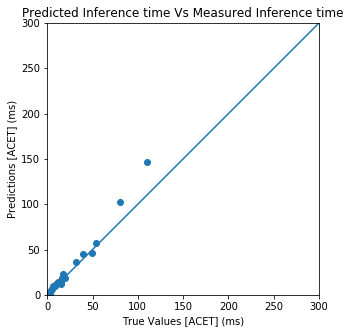

In [100]:
plt.figure(figsize=(10,5))
a = plt.axes(aspect='equal')
plt.scatter(np_test, y_pred)
plt.title('Predicted Inference time Vs Measured Inference time')
plt.xlabel('True Values [ACET] (ms)')
plt.ylabel('Predictions [ACET] (ms)')
lims = [0, 300]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.savefig('./evaluation_results/measured_vs_predicted_SVR_dim3.png', dpi=600)